In this notebook I want to find the tobac times closest to the ka times (for Morton in this case). - Julia Buhrman 03/05/2024

In [2]:
import pyart
import numpy as np
from datetime import datetime, timedelta
import glob
# from radarcalc import *
import matplotlib.pyplot as plt
import pandas as pd
import metpy.calc as mpcalc
import metpy
import metpy.plots
from metpy.units import units
import cartopy.crs as ccrs
import gc
from astropy.convolution import convolve
from boto.s3.connection import S3Connection
import tempfile
import copy
import matplotlib
import xarray as xr
import math
from datetime import datetime


## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data. Py-ART is partly
## supported by the U.S. Department of Energy as part of the Atmospheric
## Radiation Measurement (ARM) Climate Research Facility, an Office of
## Science user facility.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119



In [35]:
def dealias_Ka(radar,PPIGC_flag=False):
    '''
    This function aims to take care of all the nitty gritty customizations of pyarts dealiasing specifically for TTUKa radar data.

    Parameter: radar (pyart object), PPIGC_flag (boolean *kwarg)
    Returns: radar (pyart object) with corrected_velocity field and velocity_texture field added on

    How it works:
    1. Calculates velocity texture and creates a histogram based on all of the magnitudes of textures at each bin for the entire volume
    2. loops through each indivual sweep
    3. infinite loop to iterate between the minimum amount of texture between textures 1 and 6 and the maximum amount of texture in the histogram, with 0.5 m/s steps
    4. Each iteration, create a gatefilter that filters the bins above that texture value and dealias it with the gatefilter to ignore the high textured regions
    5. If the maximum texture is reached before breaking, set the gatefilter to mask textures above 12 m/s
    6. if the scan is an RHI, run a 2 pass variance filter along each ray.
        This convolves a 71 sized boxcar with the data, and if the difference between the point the boxcar is centered on and the mean of the boxcar is greater than the nyquist, then add/subtract 2*nyquist to that point
    7. Then, take the difference between the mean of the bottom 4 rays of the dealiased velocity in the RHI and the bottom 4 rays of the aliased velocity
    8. If the absolute difference is larger than the nyquist, the either subtract 2* nyquist or add 2*nyquist to the entire sweep and break the loop
    9. If the absolute difference is less than the nyquist, no fixes need to be applied, break the loop
    10. If the scan is a PPI, do steps 8 and 9, but skip steps 6 and 7
    11. Outside the infinite loop, add the option of the PPIGC_flag, a boolean flag that will help maintain ground clutter in PPIs at 0 m/s
        This works by identifying regions of very low spectrum width (<0.1 m/s), and setting the velocity in those regions = 0. Please note, this may introduce artificial speckles of 0 in real data, where spectrum width is noisy
    12. Apply the alias fix algorithm which convolves a boxcar of specified boxcar of size 9 with the data, and if the variance between the middle pixel of interest and the mean is greater than the nyquist, then flip it back over
    12. At the end of each sweep, assign the data from that processed sweep into a dictionary, then add the dictionary as the corrected_velocity field.
    
    The aforementioned method is FAR from perfect, but is as robust as I can do currently. One thing to improve this though is to use the UNRAVEL algorithm: https://github.com/vlouf/dealias
    The UNRAVEL algorithm shows remarkable error characteristics compared to "competitors", possibly at a time cost, which isn't a HUGE deal for us. Downside is it may not work for our "volumes" since they are temporally uncorrelated and are not full volumes through the atmosphere
    '''
    
    vel_texture = pyart.retrieve.calculate_velocity_texture(radar, vel_field='velocity', wind_size=3)
    radar.add_field('velocity_texture', vel_texture, replace_existing=True)
    hist, bins = np.histogram(radar.fields['velocity_texture']['data'][~np.isnan(radar.fields['velocity_texture']['data'])], bins=150)
    bins = (bins[1:]+bins[:-1])/2.0
    gatefilter = pyart.filters.GateFilter(radar)
    velocity_dealiased = pyart.correct.dealias_region_based(radar, vel_field='velocity', nyquist_vel=radar.instrument_parameters['nyquist_velocity']['data'][0], centered=True) #standin, data will be replaced

    for swp_id in range(radar.nsweeps):
        #get indices from beginning and ending of sweep
        sw_start = radar.sweep_start_ray_index['data'][swp_id]
        sw_end = radar.sweep_end_ray_index['data'][swp_id]+1

        counter = 0
        while True: #do an infinite loop and either break it when the data is unfolded correctly or when the max texture is reached
            #if the bin with the lowest count between textures 1 and 6 + i*0.5 is less than the maximum amount of bins
            if bins[np.where(hist==np.min(hist[find_nearest(bins,1):find_nearest(bins,6)]))[0][0]]+counter*0.5 < np.amax(bins):
                gatefilter.exclude_above('velocity_texture', bins[np.where(hist==np.min(hist[find_nearest(bins,1):find_nearest(bins,6)]))[0][0]]+counter*0.5)
                nyq = radar.instrument_parameters['nyquist_velocity']['data'][0]
                vede = pyart.correct.dealias_region_based(radar, vel_field='velocity', nyquist_vel=nyq,
                                                                        centered=True, gatefilter=gatefilter)
            else:
                gatefilter.exclude_above('velocity_texture', 12)#bins[np.where(hist==np.min(hist[find_nearest(bins,1):find_nearest(bins,6)]))[0][0]])
                nyq = radar.instrument_parameters['nyquist_velocity']['data'][0]
                vede = pyart.correct.dealias_region_based(radar, vel_field='velocity', nyquist_vel=nyq,
                                                                        centered=True, gatefilter=gatefilter)


            np.ma.set_fill_value(vede['data'], np.nan)
            #extract mask so we can apply the correct gatefilters on later
            mask=np.ma.getmask(vede['data'])

            #apply mask to velocity field and fix the small blips from dealiasing
            if radar.scan_type == 'rhi':
                #pass 1 of variance filtering along the ray.
                #Convolves a 71 sized boxcar with the data, and if the difference between the point the boxcar is centered on and the mean of the boxcar is greater than the nyquist, then add/subtract 2*nyquist to that point
                vel = vede['data'].filled()

                for sw in range(np.shape(vel)[0]):
                    mean = convolve(vel[sw,:],np.ones(71))
                    var = vel[sw,:]-mean
                    high_idx = var > nyq
                    low_idx = var < -nyq
                    vel[sw,:][high_idx] = vel[sw,:][high_idx] - 2*nyq
                    vel[sw,:][low_idx] = vel[sw,:][low_idx] + 2*nyq
                vede['data']=np.ma.masked_array(vel,mask=mask,fill_value=np.nan)

                #pass 2 of variance filtering along the ray. In case there are errant folds than need to be folded back
                vel = vede['data'].filled()
                for sw in range(np.shape(vel)[0]):
                    mean = convolve(vel[sw,:],np.ones(71))
                    var = vel[sw,:]-mean
                    high_idx = var > nyq
                    low_idx = var < -nyq
                    vel[sw,:][high_idx] = vel[sw,:][high_idx] - 2*nyq
                    vel[sw,:][low_idx] = vel[sw,:][low_idx] + 2*nyq
                vede['data']=np.ma.masked_array(vel,mask=mask,fill_value=np.nan)

                #find means of the bottom 4 rays of the RHI(should be close to 0) and compare the dealiased velocities to the aliased velocities
                np.ma.set_fill_value(radar.fields['velocity']['data'], np.nan)
                meanvelal = np.mean(radar.fields['velocity']['data'][sw_start:sw_start+4,:].filled()[~np.isnan(radar.fields['velocity']['data'][sw_start:sw_start+4,:].filled())])
                meanveldeal = np.mean(vede['data'][sw_start:sw_start+4,:].filled()[~np.isnan(vede['data'][sw_start:sw_start+4,:].filled())])
                if np.abs(meanvelal-meanveldeal) < nyq: #nyq is an arbitrary threshold and should be tuned
                    break
                if bins[np.where(hist==np.min(hist[find_nearest(bins,1):find_nearest(bins,6)]))[0][0]]+counter*0.5 < np.amax(bins):
                    if (meanvelal-meanveldeal) > 0:
                        vede['data'][sw_start:sw_end,:] += 2*nyq
                    else:
                        vede['data'][sw_start:sw_end,:] -= 2*nyq
                    break
            if radar.scan_type == 'ppi':
                np.ma.set_fill_value(radar.fields['velocity']['data'], np.nan)
                meanvelal = np.mean(radar.fields['velocity']['data'][sw_start:sw_end,:].filled()[~np.isnan(radar.fields['velocity']['data'][sw_start:sw_end,:].filled())])
                meanveldeal = np.mean(vede['data'][sw_start:sw_end,:].filled()[~np.isnan(vede['data'][sw_start:sw_end,:].filled())])
                if np.abs(meanvelal-meanveldeal) < nyq: #nyq is an arbitrary threshold and should be tuned
                    break
                if bins[np.where(hist==np.min(hist[find_nearest(bins,1):find_nearest(bins,6)]))[0][0]]+counter*0.5 < np.amax(bins):
                    if (meanvelal-meanveldeal) > 0:
                        vede['data'][sw_start:sw_end,:] += 2*nyq
                    else:
                        vede['data'][sw_start:sw_end,:] -= 2*nyq
                    break
            counter+=1
            
        #put alias fix inside here instead of calling it to make it more portable
        delta=3
        mean = convolve(vede['data'][sw_start:sw_end,:],np.ones((delta,delta))/delta**2.)
        mean[0,:] = vede['data'][sw_start:sw_end,:][0,:]
        mean[-1,:] = vede['data'][sw_start:sw_end,:][-1,:]
        var = vede['data'][sw_start:sw_end,:] - mean

        high_idx = np.logical_and(var > nyq, var < 4*nyq)
        low_idx = np.logical_and(var < -nyq, var > -4*nyq)

        vede['data'][sw_start:sw_end,:][high_idx] = vede['data'][sw_start:sw_end,:][high_idx] - 2*nyq
        vede['data'][sw_start:sw_end,:][low_idx] = vede['data'][sw_start:sw_end,:][low_idx] + 2*nyq

        #corrects ground clutter by arbitrarily setting the velocity equal to 0 where spectrum width is less than 0.075 m/s
        if PPIGC_flag == True:
            if radar.scan_type == 'ppi':
                sw = radar.fields['spectrum_width']['data'][sw_start:sw_end,:].filled()
                vel = radar.fields['velocity']['data'][sw_start:sw_end,:].filled()
                mask = sw<0.1
                vede['data'][sw_start:sw_end,:] = np.where(~mask,vede['data'][sw_start:sw_end,:],0)

        velocity_dealiased['data'][sw_start:sw_end,:] = vede['data'][sw_start:sw_end,:]
        velocity_dealiased['data'][sw_start:sw_end,:] = alias_fix(velocity_dealiased['data'][sw_start:sw_end,:],nyq,delta=9)
    radar.add_field('corrected_velocity', velocity_dealiased, replace_existing=True)

    return radar

def alias_fix(vel,nyq,delta=3):
    '''
    !!!!!!!!!!!!!!!!!!
    Removes dealiasing errors around the periphery of a folded region

    Parameters: velocity array (array), nyquist velocity (number), size of window (int, must be odd, unity is no change)
    Returns: cleaned velocity array (array)
    '''
    mean = convolve(vel,np.ones((delta,delta))/delta**2.)
    mean[0,:] = vel[0,:]
    mean[-1,:] = vel[-1,:]
    var = vel - mean

    high_idx = np.logical_and(var > nyq, var < 4*nyq)
    low_idx = np.logical_and(var < -nyq, var > -4*nyq)

    vel[high_idx] = vel[high_idx] - 2*nyq
    vel[low_idx] = vel[low_idx] + 2*nyq

    return vel

def get_radar_from_aws(site, datetime_t, datetime_te):
    """
    Get the closest volume of NEXRAD data to a particular datetime.
    Parameters
    ----------
    site : string
        four letter radar designation
    datetime_t : datetime
        desired date time
    Returns
    -------
    radar : Py-ART Radar Object
        Radar closest to the queried datetime
    """

    # First create the query string for the bucket knowing
    # how NOAA and AWS store the data
    my_pref = datetime_t.strftime('%Y/%m/%d/') + site

    # Connect to the bucket
    conn = S3Connection(anon = True)
    bucket = conn.get_bucket('noaa-nexrad-level2')

    # Get a list of files
    bucket_list = list(bucket.list(prefix = my_pref))

    # we are going to create a list of keys and datetimes to allow easy searching
    keys = []
    datetimes = []

    # populate the list
    for i in range(len(bucket_list)):
        this_str = str(bucket_list[i].key)
        if 'gz' in this_str:
            endme = this_str[-22:-4]
            fmt = '%Y%m%d_%H%M%S_V0'
            dt = datetime.strptime(endme, fmt)
            datetimes.append(dt)
            keys.append(bucket_list[i])

        if this_str[-3::] == 'V06':
            endme = this_str[-19::]
            fmt = '%Y%m%d_%H%M%S_V06'
            dt = datetime.strptime(endme, fmt)
            datetimes.append(dt)
            keys.append(bucket_list[i])

    # find the closest available radar to your datetime
    closest_datetime_b = _nearestDate(datetimes, datetime_t)
    closest_datetime_e = _nearestDate(datetimes, datetime_te)

    index_b = datetimes.index(closest_datetime_b)
    index_e = datetimes.index(closest_datetime_e)

    radar_namelist = keys[index_b:index_e+1]
    radar_list=[]
    for i in range(np.shape(radar_namelist)[0]):
        localfile = tempfile.NamedTemporaryFile()
        radar_namelist[i].get_contents_to_filename(localfile.name)
        radar_list.append(pyart.io.read(localfile.name))
    return radar_namelist,radar_list

def getLocation(lat1, lon1, brng, distancekm):
    lat1 = lat1 * np.pi / 180.0
    lon1 = lon1 * np.pi / 180.0
    #earth radius
    R = 6378.1
    #R = ~ 3959 MilesR = 3959
    bearing = (brng / 90.)* np.pi / 2.

    lat2 = np.arcsin(np.sin(lat1) * np.cos(distancekm/R) + np.cos(lat1) * np.sin(distancekm/R) * np.cos(bearing))
    lon2 = lon1 + np.arctan2(np.sin(bearing)*np.sin(distancekm/R)*np.cos(lat1),np.cos(distancekm/R)-np.sin(lat1)*np.sin(lat2))
    lon2 = 180.0 * lon2 / np.pi
    lat2 = 180.0 * lat2 / np.pi
    return lat2, lon2

def _nearestDate(dates, pivot):
    return min(dates, key=lambda x: abs(x - pivot))

def find_nearest(array, value):
    '''
    Function to find index of the array in which the value is closest to

    Parameters: array (array), value (number)
    Returns: index (int)

    Example: xind = CM1calc.find_nearest(x,5)
    '''

    array = np.asarray(array)
    idx = (np.abs(array-value)).argmin()
    return idx


def vehicle_correction_vad(radar,df):
    '''
    Function that creates a 'vad_corrected_velocity' field that can be used for vad calculations, 
    but should be general enough to use for stationary VADs as well as moving PPIs. 
    Other than adding the new field, the radar times are smoothly interpolated and the azimuths are 
    corrected via the GPS pandas dataframe.
    
    Parameters: pyart radar object (object), pandas dataframe of appropriate radarGPS file (dataframe)
    Returns: pyart radar object (object), speed (float), speed variance (float), bearing (float), bearing variance (float), 
             latitude (float), latitude variance (float), longitude (float), longitude variance (float)
    
    Example: radar, velmean, velvar, bearmean, bearvar, latmean, latvar, lonmean, lonvar = vehicle_correction_vad(radar,df)

    p.s. only works if the velocity is already dealiased and there is a 'corrected_velocity' field
         also only works if a single sweep is extracted, example: radar = radar.extract_sweeps([0])
    '''
    
    #orders the time to increase monotonically instead of having a massive step jump in the middle
    roll_mag = (np.argmax(np.abs(np.gradient(radar.time['data'])))+1)
    times = np.roll(radar.time['data'],-roll_mag) 
    
    #a complicated way to create linear increasing times (instead of steps) that start at 0 seconds after the time datum and increase to the middle of the second max time plateau (if confused, plotting it is helpful)
    #from now on, we are going to assume ray_times is the fractional seconds after the time datum the ray is gathered, and we need to roll it back to match with the rest of the data
    ray_times = np.roll(np.arange(0,((np.unique(times)[-2])/(find_nearest(times,np.unique(times)[-2])+int(np.sum(radar.time['data']==np.unique(times)[-2])/2)))*len(times)+1e-11,((np.unique(times)[-2])/(find_nearest(times,np.unique(times)[-2])+int(np.sum(radar.time['data']==np.unique(times)[-2])/2)))),roll_mag)

    radar.time['data']=ray_times


    df['datetime'] = [datetime.strptime(d,'%d%m%y%H%M%S') for d in df['ddmmyy']+df['hhmmss[UTC]']]
    print(df)
    beginscanindex = df.loc[df['datetime'] == datetime.strptime(radar.time['units'],'seconds since %Y-%m-%dT%H:%M:%SZ')].index
    endscanindex = df.loc[df['datetime'] == datetime.strptime(radar.time['units'],'seconds since %Y-%m-%dT%H:%M:%SZ')].index+np.ceil(np.amax(ray_times))+1
    dfscan = df.iloc[beginscanindex[0].astype(int):endscanindex[0].astype(int)]
    dfscan = dfscan.astype({'Bearing[degrees]': 'float'})
    dfscan = dfscan.astype({'Velocity[knots]': 'float'})

    ray_bearings = np.interp(ray_times,np.arange(len(dfscan)),dfscan['Bearing[degrees]'])
    ray_speeds = np.interp(ray_times,np.arange(len(dfscan)),dfscan['Velocity[knots]'])

    print('velocity [kts]',dfscan['Velocity[knots]'].mean(),'+-',dfscan['Velocity[knots]'].var())
    speed = dfscan['Velocity[knots]'].mean()
    print('bearing',dfscan['Bearing[degrees]'].mean(),'+-',dfscan['Bearing[degrees]'].var())
    bearing = dfscan['Bearing[degrees]'].mean()
    print('latitude',dfscan['Latitude'].astype(float).mean(),'+-',dfscan['Latitude'].astype(float).var())
    lat = dfscan['Latitude'].astype(float).mean()
    print('longitude',dfscan['Longitude'].astype(float).mean(),'+-',dfscan['Longitude'].astype(float).var())
    lon = dfscan['Longitude'].astype(float).mean()

    radar.azimuth['data'] += ray_bearings[:-1] #bearing

    rad_vel = copy.deepcopy(radar.fields['corrected_velocity'])

    rad_vel['data']+=(np.cos(np.deg2rad(radar.azimuth['data']-ray_bearings[:-1]))*(ray_speeds[:-1]/1.94384)*np.cos(np.deg2rad(radar.fixed_angle['data'][0])))[:,np.newaxis]

    #fix mask, remove points very close to radar as well as the very last bin, more often than not, = bad data
    rad_vel['data'].mask[:,:5] = True
    rad_vel['data'].mask[:,-1] = True
    radar.add_field('vad_corrected_velocity', rad_vel, replace_existing=True)

    return radar, dfscan['Velocity[knots]'].mean(),dfscan['Velocity[knots]'].var(),dfscan['Bearing[degrees]'].mean(),dfscan['Bearing[degrees]'].var(),dfscan['Latitude'].astype(float).mean(),dfscan['Latitude'].astype(float).var(),dfscan['Longitude'].astype(float).mean(),dfscan['Longitude'].astype(float).var()
    

Bring in the data:

In [38]:
all_dealiased_data_ka1 = sorted(glob.glob('/Users/juliabman/Desktop/dealiased_data/Ka1*.nc'))
ka1gps = pd.read_csv('/Users/juliabman/Desktop/research2024/GPS_Ka1_20220523.txt')
tobac_file = '/Users/juliabman/Desktop/research2024/tobac_Save/Track.nc'

In [39]:
ka1gps['ddmmyy'] = ka1gps['ddmmyy'].astype(str)
ka1gps['hhmmss[UTC]'] = ka1gps['hhmmss[UTC]'].astype(str)

In [4]:
tobac_features_xr = xr.open_dataset(tobac_file)

In [5]:
tobac_features_xr

<xarray.Dataset>
Dimensions:                  (index: 851)
Coordinates:
  * index                    (index) int64 0 1 2 3 4 5 ... 846 847 848 849 850
Data variables: (12/15)
    frame                    (index) int64 ...
    idx                      (index) int64 ...
    hdim_1                   (index) float64 ...
    hdim_2                   (index) float64 ...
    num                      (index) int64 ...
    threshold_value          (index) int64 ...
    ...                       ...
    projection_y_coordinate  (index) float64 ...
    projection_x_coordinate  (index) float64 ...
    latitude                 (index) float64 ...
    longitude                (index) float64 ...
    cell                     (index) int64 ...
    time_cell                (index) timedelta64[ns] ...

In [6]:
tobac_times = tobac_features_xr['time']

In [7]:
tobac_times

<xarray.DataArray 'time' (index: 851)>
[851 values with dtype=datetime64[ns]]
Coordinates:
  * index    (index) int64 0 1 2 3 4 5 6 7 8 ... 843 844 845 846 847 848 849 850

In [27]:
tobac_lats = np.array(tobac_features_xr['latitude'])
tobac_lons = np.array(tobac_features_xr['longitude'])

In [8]:
dealiased_vad_ka1_times = []
for time_grab in range(len(all_dealiased_data_ka1)):
    file = all_dealiased_data_ka1[time_grab]
    time_yoink = file[43:-13]
    time_yoink_datetime = datetime.strptime(time_yoink, '%y%m%d%H%M%S')
    dealiased_vad_ka1_times.append(time_yoink_datetime)

In [9]:
#dealiased_vad_ka1_times

Convert lists of times to arrays of times so we can do math on them (you can't do math on lists)

In [10]:
array_dealiased_vad_ka1_times = np.array(dealiased_vad_ka1_times)
array_tobac_times = np.array(tobac_times)

In [11]:
type(array_tobac_times)

numpy.ndarray

In [12]:
array_dealiased_vad_ka1_times_datetime = array_dealiased_vad_ka1_times.astype('datetime64[s]')
array_tobac_times_datetime = array_tobac_times.astype('datetime64[s]')

Make a loop that iterates through the ka times and subtracts them through the tobac times, and whichever has the smallest result print that datetime

In [28]:
tobac_times_aligning_with_ka = []
tobac_matching_lats = []
tobac_matching_lons = []
for a_ka_time in array_dealiased_vad_ka1_times_datetime:
    absolute_diff_between_times = np.abs(array_tobac_times_datetime - a_ka_time)
    #print(absolute_diff_between_times)
    index_of_smallest_time_between = np.argmin(absolute_diff_between_times) # np.argmin returns the index of the min value
    # access the index of the smallest value
    access_smallest_value = array_tobac_times[index_of_smallest_time_between]
    tobac_lats_for_ka = tobac_lats[index_of_smallest_time_between]
    tobac_lons_for_ka = tobac_lons[index_of_smallest_time_between]
    #print(f"the ka time is {a_ka_time}")
    #print(f" the tobac time is {access_smallest_value}")
    tobac_times_aligning_with_ka.append(access_smallest_value)
    tobac_matching_lats.append(tobac_lats_for_ka)
    tobac_matching_lons.append(tobac_lons_for_ka)

In [31]:
#tobac_matching_lats

In [32]:
np.size(tobac_matching_lats)

307

In [44]:
tobac_matching_lats_0523 = tobac_matching_lats[:188]
tobac_matching_lons_0523 = tobac_matching_lons[:188]

In [41]:
corrected_vehicle_vads_0523 = []
corrected_vads_file_names_0523 = []
radar_array = []
velmean_array = []
velvar_array = []
bearmean_array = []
latmean_array = []
latvar_array = []
lonmean_array = []
lonvar_array = []

for uncorrected_vad in all_dealiased_data_ka1[:]:
    print(uncorrected_vad)
    read = pyart.io.read_cfradial(uncorrected_vad)
    
    radar, velmean, velvar, bearmean, bearvar, latmean, latvar, lonmean, lonvar = vehicle_correction_vad(read, ka1gps)
    #corrected_vehicle_vads_0523.append(correction_function)
    radar_array.append(radar)
    velmean_array.append(velmean)
    velvar_array.append(velvar)
    bearmean_array.append(bearmean)
    latmean_array.append(latmean)
    latvar_array.append(latvar)
    lonmean_array.append(lonmean)
    lonvar_array.append(lonvar)
    corrected_vads_file_names_0523.append(uncorrected_vad)

/Users/juliabman/Desktop/dealiased_data/Ka1220523201819_dealiased.nc
       ddmmyy hhmmss[UTC]   Longitude   Latitude  Velocity[knots]  \
0      230522      183124 -102.031783  33.588547             0.00   
1      230522      183125 -102.031783  33.588547             0.00   
2      230522      183126 -102.031783  33.588547             0.00   
3      230522      183127 -102.031783  33.588547             0.00   
4      230522      183128 -102.031783  33.588547             0.00   
...       ...         ...         ...        ...              ...   
31901  240522       32353 -102.032235  33.589625             0.22   
31902  240522       32354 -102.032227  33.589630             0.50   
31903  240522       32355 -102.032210  33.589645             1.53   
31904  240522       32356 -102.032200  33.589662             3.10   
31905  240522       32357 -102.032198  33.589678             3.06   

       Bearing[degrees]            datetime  
0                140.92 2022-05-23 18:31:24  
1         

IndexError: index 0 is out of bounds for axis 0 with size 0

In [45]:
np.size(latmean_array)

188

We now have the lats and lons in order!! Let's put them into the distance function:

In [46]:
# from stackoverflow (https://stackoverflow.com/questions/639695/how-to-convert-latitude-or-longitude-to-meters)
# originally in javascript
def measure(lat1, lon1, lat2, lon2):  # generally used geo measurement function
    R = 6378.137 # Radius of earth in KM
    dLat = lat2 * np.pi / 180 - lat1 * np.pi / 180;
    dLon = lon2 * np.pi / 180 - lon1 * np.pi / 180;
    a = np.sin(dLat/2) * np.sin(dLat/2) + np.cos(lat1 * np.pi / 180) * np.cos(lat2 * np.pi / 180) * np.sin(dLon/2) * np.sin(dLon/2)
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1-a))
    d = R * c
    #d_meters = d * 1000
    return d # km

In [49]:
ka1_distance_from_storm_0523 = []
for index in np.arange(0, len(latmean_array)):
    distance = measure(latmean_array[index], lonmean_array[index], tobac_matching_lats[index], tobac_matching_lons[index])
    ka1_distance_from_storm_0523.append(distance)

In [51]:
#ka1_distance_from_storm_0523

In [63]:
from math import sin, cos, sqrt, atan2, radians

def calc_velocity(lat1,lon1,lat2,lon2,time1,time2):
    R = 6371 # Radius of the earth in km
    dLat = radians(lat2-lat1)
    dLon = radians(lon2-lon1)
    rLat1 = radians(lat1)
    rLat2 = radians(lat2)
    a = sin(dLat/2) * sin(dLat/2) + cos(rLat1) * cos(rLat2) * sin(dLon/2) * sin(dLon/2) 
    c = 2 * atan2(sqrt(a), sqrt(1-a))
    d = R * c * 1000 # Distance in m
    return d / ((time2 - time1)/1e9) # dividing by 1e9 because the times are in nanoseconds

def get_bearing(lat1, long1, lat2, long2):
    dLon = (long2 - long1)
    x = cos(radians(lat2)) * sin(radians(dLon))
    y = cos(radians(lat1)) * sin(radians(lat2)) - sin(radians(lat1)) * cos(radians(lat2)) * cos(radians(dLon))
    brng = np.arctan2(x,y)
    brng = (np.degrees(brng)+180) % 360
    return brng

In [64]:
storm_velocity=[]
storm_direction=[]
time_initial = tobac_times_aligning_with_ka[0].astype(float)
time_final = tobac_times_aligning_with_ka[-1].astype(float)

for i in np.arange(0,len(tobac_matching_lats_0523)-1,1): # using storm_lat as length makes these plots different that plot test 2, which uses length of storm location csv
    velocity = calc_velocity(tobac_matching_lats_0523[i], tobac_matching_lons_0523[i],
                             tobac_matching_lats_0523[i+1],tobac_matching_lons_0523[i+1],
                             time_initial, time_final)
                             #storm_decimalsec[i],storm_decimalsec[i+1])
    storm_velocity.append(velocity)
    
    direction = get_bearing(tobac_matching_lats_0523[i],tobac_matching_lons_0523[i],
                            tobac_matching_lats_0523[i+1], tobac_matching_lons_0523[i+1])
    storm_direction.append(direction)
    
storm_velocity = np.append([np.nan],storm_velocity) # in meters/sec
storm_direction = np.append([np.nan],storm_direction) # in degrees

In [67]:
#storm_direction

In [68]:
velocitydf = pd.DataFrame(storm_velocity)

velocity_corrected = velocitydf.dropna()

avg_storm_velocity = np.average(velocity_corrected)

In [69]:
avg_storm_velocity

0.5426329570054179

In [70]:
storm_directiondf = pd.DataFrame(storm_direction)

direction_corrected = storm_directiondf.dropna()

avg_storm_direction = np.average(direction_corrected)

In [71]:
avg_storm_direction

182.44245933104523

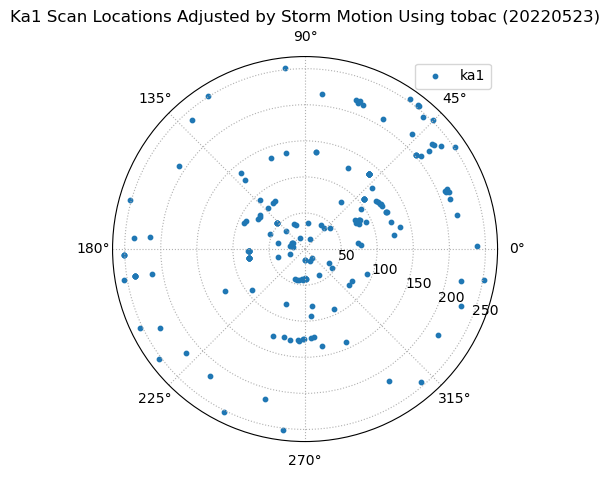

In [72]:
# bring in the figure

fig = plt.figure(figsize = (5,5))
ax = fig.add_subplot(projection = 'polar')
ax.set_rmax(2)
#ax.set_rticks(distance_grid)
ax.set_rlabel_position(-22.5)  # Move radial labels away from plotted line
ax.grid(True, linestyle = ':') # makes grid lines dotted
#ax.set_theta_zero_location('W', avg_storm_direction) # what is the N, S, E, W good for?
#ax.set_theta_offset(avg_storm_direction)
ax.set_title("Ka1 Scan Locations Adjusted by Storm Motion Using tobac (20220523)")
ax.plot()

# now that we have the figure set up, we can plot on it
# r --> great circle distance from lat and lon of storm to lat and lon of vehicle
# theta --> corrected bearing
# in polar plots the order of plotting is (theta, r)
theta = bearmean_array
r = ka1_distance_from_storm_0523 # 37 of the dfs indeces, these inclue the last of the list, so they're closer to the storm

# theta2 = bearing_list_ka2
# r2 = ka2_distance_from_storm[0:64]

ka1 = ax.scatter(theta, r, s = 10) # s changes point size
# ka2 = ax.scatter(theta2, r2, s = 10)

# ax.legend(['ka1', 'ka2'])
ax.legend(['ka1'])
# plt.savefig('/Users/juliabman/Desktop/Seminar_Pictures/both_ka_positions.png')
plt.show()

I'm not sure how accurate the distances from the storm are since the storm's lat and lon are plot at the reflectivity max of the storm, not necessarily the inflow...